In [87]:
import numpy as np
import lmfit
import matplotlib.pyplot as plt
plt.style.use("seaborn-colorblind")

# Data

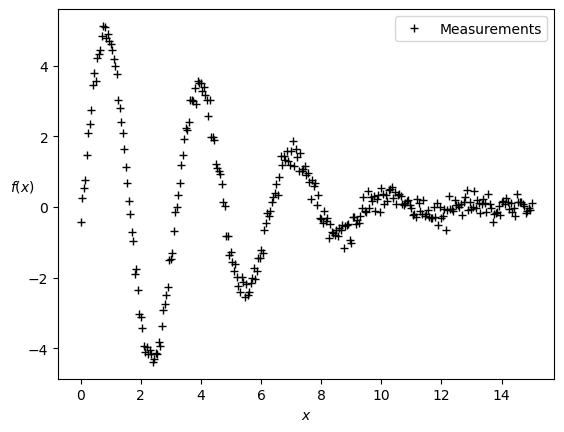

In [88]:
# create data to be fitted (we construct it in such a way that it does follow this model, just with noise)
x = np.linspace(0, 15, 301)
noise = np.random.normal(size=len(x), scale=0.2)
data = 5.0 * np.sin(2*x - 0.1) * np.exp(-x*x*0.025) + noise


plt.plot(x, data, 'k+',label="Measurements")
plt.ylabel(r"$f(x)$", rotation=0)
plt.xlabel(r"$x$")
plt.legend()
plt.show()

# Model
Lets say we measure data (amplitude of a certain oscillator over time perhaps) and wish to model it with a function we have determined to be appropriate

$$ f(x) = A\sin(\omega x + \delta) e^{-\lambda x^2} $$

**Known:**
- $f$ is the function we measure (we may know a collection of values of $f$, called $\{f_i\}$ at values of the independent variable $\{x_i\}$)
- $x$ is the independent variable, such as time in the case of measuring the amplitude of an oscillator

**Unknown:** (parameters in the model)
- $A\longrightarrow$  An amplitude
- $\omega\longrightarrow$ An oscillation frequency
- $\delta\longrightarrow$ An offset or "shift"
- $\lambda\longrightarrow$ A decay

In [89]:
# define objective function: returns the array to be minimized
def model_data_difference(params, x, data): # make sure params is first, and the other arguments will be passed by "fcn_args" in the minimizer
    """Model a decaying sine wave and subtract data."""
    amp = params['amp']
    shift = params['shift']
    omega = params['omega']
    decay = params['decay']

    model = amp * np.sin(x*omega + shift) * np.exp(-x*x*decay)
    return model - data


# create a set of Parameters
params = lmfit.Parameters()
params.add('amp', value=10, min=0)
params.add('decay', value=0.1)
params.add('shift', value=0.0, min=-np.pi/2., max=np.pi/2)
params.add('omega', value=3.0)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 59
    # data points      = 301
    # variables        = 4
    chi-square         = 10.8771614
    reduced chi-square = 0.03662344
    Akaike info crit   = -991.453933
    Bayesian info crit = -976.625492
[[Variables]]
    amp:    4.98830605 +/- 0.03771090 (0.76%) (init = 10)
    decay:  0.02467050 +/- 4.2629e-04 (1.73%) (init = 0.1)
    shift: -0.09584606 +/- 0.00972528 (10.15%) (init = 0)
    omega:  1.99991178 +/- 0.00308387 (0.15%) (init = 3)
[[Correlations]] (unreported correlations are < 0.100)
    C(shift, omega) = -0.786
    C(amp, decay)   = 0.584
    C(amp, shift)   = -0.118


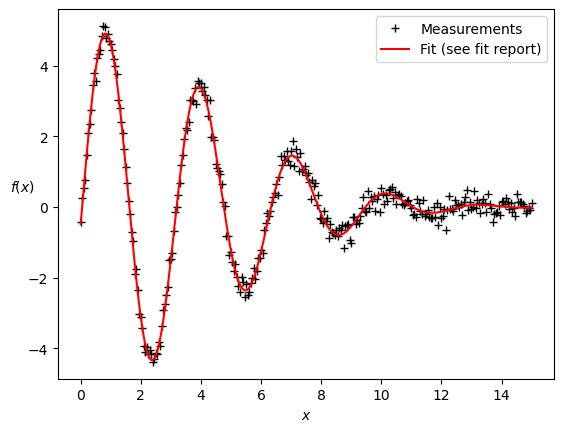

In [90]:
# do fit, here with leastsq model
minimizer_instance = lmfit.Minimizer(model_data_difference, params, fcn_args=(x, data))
result = minimizer_instance.minimize()

# calculate final result
final = data + result.residual  # after minimizing, residual = final model estimate - real data

# write error report
lmfit.report_fit(result)

#plot results
plt.plot(x, data, 'k+', label = "Measurements")
plt.plot(x, final, 'r', label = f"Fit (see fit report)")
plt.ylabel(r"$f(x)$", rotation=0)
plt.xlabel(r"$x$")
plt.legend()
plt.show()

# Second Example

#### Make data

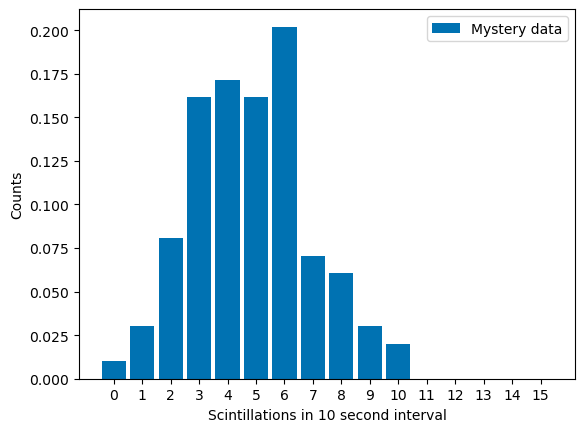

In [195]:
mystery_data = np.random.normal(5.0,2.0,100) #np.random.poisson(5, 100)

max_bin = 15
offset = 0.5
bin_centers = np.arange(0, max_bin + 1, 1)
bin_edges = bin_centers - offset
bin_edges = np.append(bin_edges, max_bin + offset) # add in the last (rightmost) edge

counts, bins, ignored = plt.hist(mystery_data, rwidth=0.85, bins=bin_edges, label="Mystery data",density=True)

# ------------- IGNORE THIS COMMENT ----------------
# We dont normalize so our chi2 results make sense, see 
# https://stats.stackexchange.com/questions/114859/can-we-run-a-chi-squared-test-on-a-normalized-function
# If we wanted to normalize and not fit the amplitude, would need to rescale chi2 values obtained by multiplying 
# by the total number of observations times the bin width (here, 1).

plt.xlabel("Scintillations in 10 second interval")
plt.xticks(bin_centers)
plt.ylabel("Counts")
plt.legend()
plt.show()

#### Define model (Gaussian)

In [196]:
from scipy.stats import norm, chi2 # normal distribution, chi squared distribution


# Note this can be implemented in a different manner using https://lmfit.github.io/lmfit-py/model.html
def model_mystery_data_difference_Gaussian(params, bin_centers, data_counts):
    """Model the mystery data by a Gaussian with mean and deviation in params, evaluate at bin_centers, return difference of model and data
       Both the model and the data are normalized. Ensure data is appropriately scaled to be normalized
    """
    amp = params['amp']
    mu = params['mu']
    sigma = params['sigma']

    model = amp * norm.pdf(bin_centers, mu, sigma)

    return model - data_counts


# create a set of Parameters
params_Gaussian = lmfit.Parameters()
params_Gaussian.add('amp', value=1)
params_Gaussian.add('mu', value=3)
params_Gaussian.add('sigma', value=2, min=0.1)

#### Fit model (Gaussian)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 16
    # variables        = 3
    chi-square         = 0.00490528
    reduced chi-square = 3.7733e-04
    Akaike info crit   = -123.440522
    Bayesian info crit = -121.122756
[[Variables]]
    amp:    1.00509412 +/- 0.06530408 (6.50%) (init = 1)
    mu:     4.69238240 +/- 0.15769753 (3.36%) (init = 3)
    sigma:  2.10767722 +/- 0.15898708 (7.54%) (init = 2)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, sigma) = 0.582


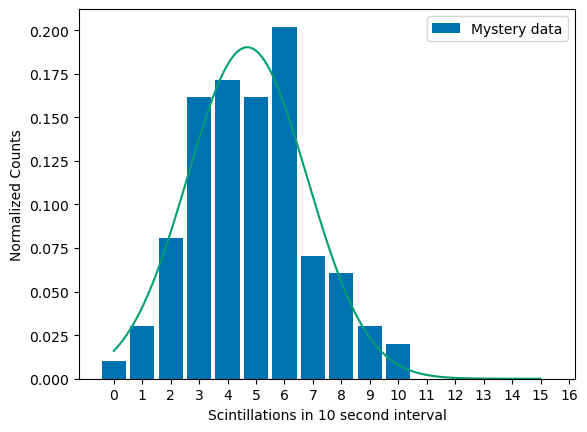

In [197]:
# do fit, here with leastsq model
minimizer_instance_Gaussian = lmfit.Minimizer(model_mystery_data_difference_Gaussian, params_Gaussian, fcn_args=(bin_centers, counts))
result_Gaussian = minimizer_instance_Gaussian.minimize()

# calculate final result
dense_scintillations = np.linspace(0,max_bin, 1000)
fit_amp = result_Gaussian.params['amp'].value
fit_mean = result_Gaussian.params['mu'].value
fit_sigma = result_Gaussian.params['sigma'].value

fit_Gaussian = fit_amp*norm.pdf(dense_scintillations, fit_mean, fit_sigma)


# write error report
lmfit.report_fit(result_Gaussian)

#plot results
count, bins, ignored = plt.hist(mystery_data, rwidth=0.85, bins=bin_edges, label="Mystery data",density=True)
plt.plot(dense_scintillations, fit_Gaussian)
plt.xlabel("Scintillations in 10 second interval")
plt.xticks(bin_edges + offset)
plt.ylabel("Normalized Counts")
plt.legend()
plt.show()

In [198]:
# Probability of getting a chi2 less than result_Gaussian.chisqr for our number of degrees of freedom is 
chi2.cdf(result_Gaussian.chisqr , df=result_Gaussian.nfree)

5.74859342761912e-21

In [ ]:
# Thats a weird number.